# Credit Card Fraud Detection

## Project overview


In this machine learning (ML) project, our objective is to develop robust models for the
detection of fraudulent credit card transactions. We will utilize a dataset containing
transaction information and employ various ML algorithms, including Logistic Regression,
Decision Trees, and Random Forests, to classify transactions into either fraudulent or
legitimate categories.

## About the Dataset


We have access to a simulated credit card transaction dataset containing legitimate and
fraudulent transactions over a span of two years, from 2019 to 2020. This dataset
includes transactions made by 1000 customers with a diverse group of 800 merchants.
Notably, the dataset exhibits severe class imbalance in terms of target classes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils.class_weight import compute_sample_weight 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score,roc_curve,make_scorer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

## Load training Data

In [2]:
train_data = pd.read_csv("fraudTrain.csv")
pd.options.display.max_columns=50
pd.options.display.max_rows=100
train_data.head()               

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


## Load testing data 

In [3]:
test_data = pd.read_csv("fraudTest.csv")
test_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


# data cleaning

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [6]:
train_data.isnull().sum().sum()

0

In [7]:
test_data.isnull().sum().sum()

0

In [8]:
train_data.duplicated().sum()

0

In [9]:
test_data.duplicated().sum()

0

## Exploratory Data Analysis


### Summary Statistics

In [10]:
num_columns = train_data.select_dtypes(include=np.number).columns
num_columns

Index(['Unnamed: 0', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop',
       'unix_time', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [11]:
train_data[num_columns].describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [12]:
cat_columns = train_data.select_dtypes(exclude=np.number).columns
cat_columns

Index(['trans_date_trans_time', 'merchant', 'category', 'first', 'last',
       'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num'],
      dtype='object')

In [13]:
train_data[cat_columns].describe()

,trans_date_trans_time,merchant,category,first,last,gender,street,city,state,job,dob,trans_num
count,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675
unique,1274791,693,14,352,481,2,983,894,51,494,968,1296675
top,2019-04-22 16:02:01,fraud_Kilback LLC,gas_transport,Christopher,Smith,F,0069 Robin Brooks Apt. 695,Birmingham,TX,Film/video editor,1977-03-23,0b242abb623afc578575680df30655b9
freq,4,4403,131659,26669,28794,709863,3123,5617,94876,9779,5636,1


## Visualization

### The Target Imbalance

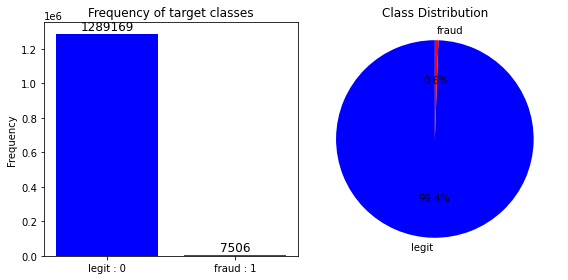

In [14]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.bar(['legit : 0', 'fraud : 1'], train_data["is_fraud"].value_counts(), color=['blue', 'red'])
for i, count in enumerate(train_data["is_fraud"].value_counts()):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12, color='black')
plt.title("Frequency of target classes")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
plt.pie(train_data["is_fraud"].value_counts(), labels=['legit', 'fraud'], autopct='%1.1f%%', colors=['blue', 'red'], startangle=90)
plt.axis('equal') 
plt.title('Class Distribution')

plt.tight_layout()
plt.show()


In [15]:
train_data["amt"].describe()

count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64

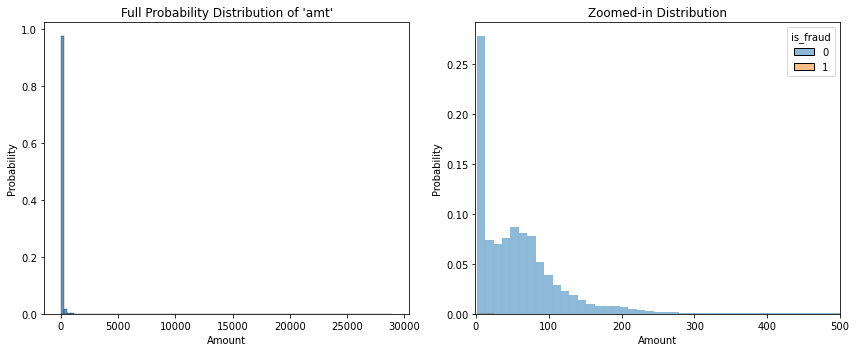

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=train_data, x='amt', stat='probability', bins=100, ax=axes[0])
axes[0].set_title("Full Probability Distribution of 'amt'")
axes[0].set_xlabel("Amount")
axes[0].set_ylabel("Probability")
sns.histplot(data=train_data, x='amt', bins=2500, stat='probability', hue='is_fraud', ax=axes[1])
axes[1].set_xlim(-1, 500) 
axes[1].set_title("Zoomed-in Distribution")
axes[1].set_xlabel("Amount")
axes[1].set_ylabel("Probability")
plt.tight_layout()
plt.show()

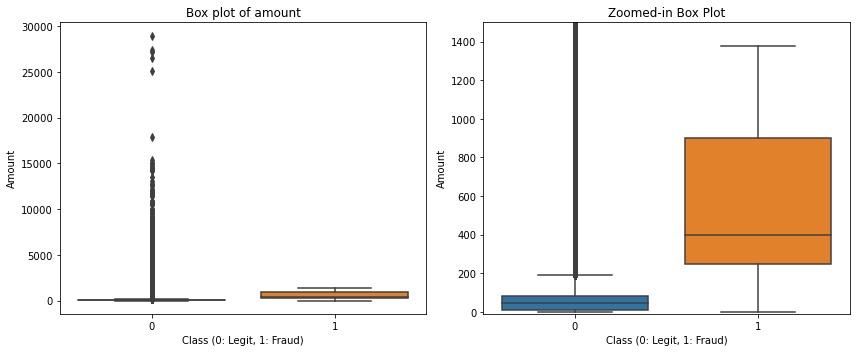

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=train_data, x='is_fraud', y='amt')
plt.title("Box plot of amount")
plt.xlabel("Class (0: Legit, 1: Fraud)")
plt.ylabel("Amount")
plt.subplot(1, 2, 2)
sns.boxplot(data=train_data, x='is_fraud', y='amt')
plt.ylim(-10, 1500)
plt.title("Zoomed-in Box Plot")
plt.xlabel("Class (0: Legit, 1: Fraud)")
plt.ylabel("Amount")

plt.tight_layout()
plt.show()


In [18]:
train_data["city_pop"].describe()

count    1.296675e+06
mean     8.882444e+04
std      3.019564e+05
min      2.300000e+01
25%      7.430000e+02
50%      2.456000e+03
75%      2.032800e+04
max      2.906700e+06
Name: city_pop, dtype: float64

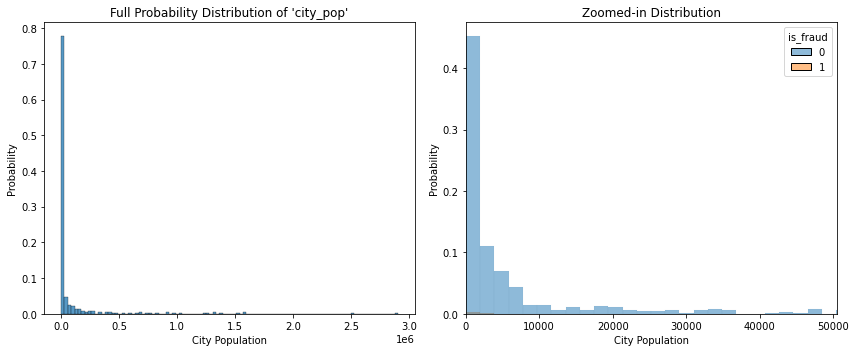

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=train_data, x='city_pop', stat='probability', bins=100, ax=axes[0])
axes[0].set_title("Full Probability Distribution of 'city_pop'")
axes[0].set_xlabel("City Population")
axes[0].set_ylabel("Probability")
sns.histplot(data=train_data, x='city_pop', bins=1500, stat='probability', hue='is_fraud', ax=axes[1])
axes[1].set_xlim(-1, 50500)
axes[1].set_title("Zoomed-in Distribution")
axes[1].set_xlabel("City Population")
axes[1].set_ylabel("Probability")

plt.tight_layout()
plt.show()


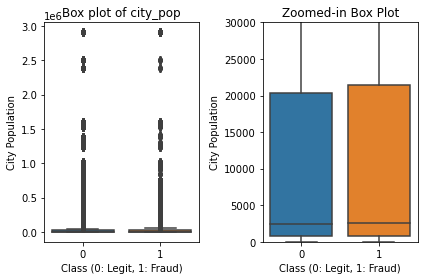

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplot(1, 2, 1)
sns.boxplot(data=train_data, x='is_fraud', y='city_pop')
plt.title("Box plot of city_pop")
plt.xlabel("Class (0: Legit, 1: Fraud)")
plt.ylabel("City Population")
plt.subplot(1, 2, 2)
sns.boxplot(data=train_data, x='is_fraud', y='city_pop')
plt.ylim(-1, 30000)
plt.title("Zoomed-in Box Plot")
plt.xlabel("Class (0: Legit, 1: Fraud)")
plt.ylabel("City Population")

plt.tight_layout()
plt.show()



In [21]:
train_data["unix_time"].describe()

count    1.296675e+06
mean     1.349244e+09
std      1.284128e+07
min      1.325376e+09
25%      1.338751e+09
50%      1.349250e+09
75%      1.359385e+09
max      1.371817e+09
Name: unix_time, dtype: float64

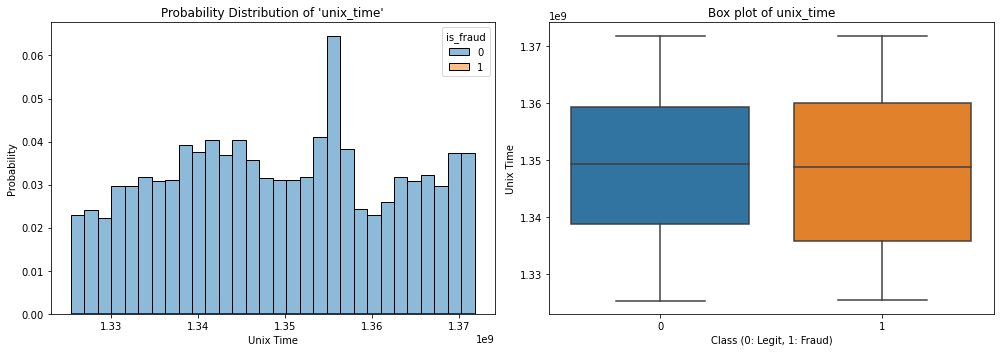

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data=train_data, x='unix_time', stat='probability', bins=30, hue='is_fraud', ax=axes[0])
axes[0].set_title("Probability Distribution of 'unix_time'")
axes[0].set_xlabel("Unix Time")
axes[0].set_ylabel("Probability")
sns.boxplot(data=train_data[['unix_time', 'is_fraud']], x='is_fraud', y='unix_time', ax=axes[1])
axes[1].set_title("Box plot of unix_time")
axes[1].set_xlabel("Class (0: Legit, 1: Fraud)")
axes[1].set_ylabel("Unix Time")

plt.tight_layout()
plt.show()


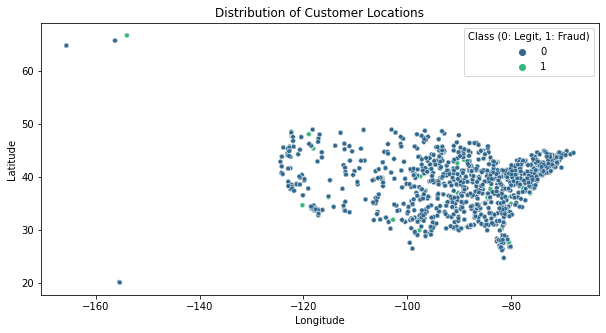

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.scatterplot(data=train_data, x='long', y='lat', hue='is_fraud', palette='viridis', s=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Distribution of Customer Locations")
plt.legend(title='Class (0: Legit, 1: Fraud)')
plt.show()

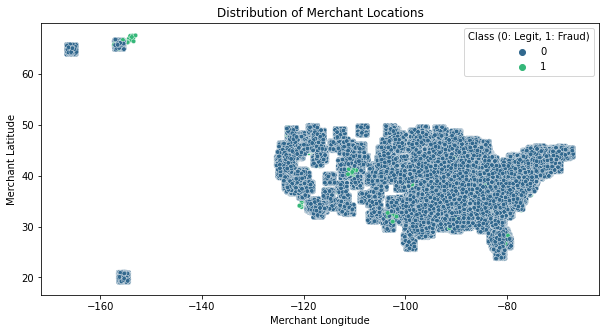

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.scatterplot(data=train_data, x='merch_long', y='merch_lat', hue='is_fraud', palette='viridis', s=20)
plt.xlabel('Merchant Longitude')
plt.ylabel('Merchant Latitude')
plt.title("Distribution of Merchant Locations")
plt.legend(title='Class (0: Legit, 1: Fraud)')
plt.show()

[Text(0.5, 1.0, 'Category Distribution for Legitimate and Fraudulent Transactions'),
 Text(0.5, 0, 'Category'),
 Text(0, 0.5, 'Count')]

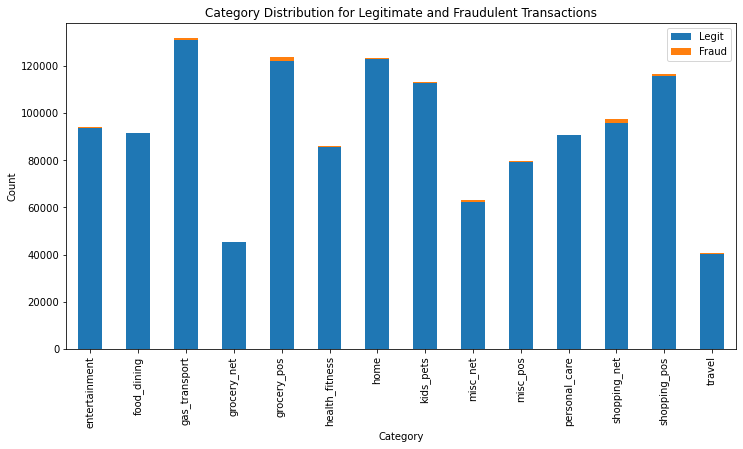

In [25]:
cat_counts = pd.DataFrame({'Legit': train_data[train_data.is_fraud == 0]["category"].value_counts(), 'Fraud': train_data[train_data.is_fraud == 1]["category"].value_counts()}).fillna(0)
cat_counts.plot(kind='bar', stacked=True, figsize=(12, 6)).set(title="Category Distribution for Legitimate and Fraudulent Transactions", xlabel="Category", ylabel="Count")

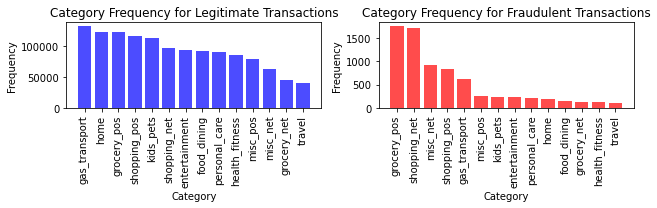

In [26]:
cat_count_legit = train_data[train_data.is_fraud == 0]["category"].value_counts()
cat_count_fraud = train_data[train_data.is_fraud == 1]["category"].value_counts()
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.bar(cat_count_legit.index, cat_count_legit, alpha=0.7, color='b')
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.xlabel("Category")
plt.title("Category Frequency for Legitimate Transactions")
plt.subplot(1, 2, 2)
plt.bar(cat_count_fraud.index, cat_count_fraud, alpha=0.7, color='r')
plt.xticks(rotation=90)
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.title("Category Frequency for Fraudulent Transactions")

plt.tight_layout()
plt.show()

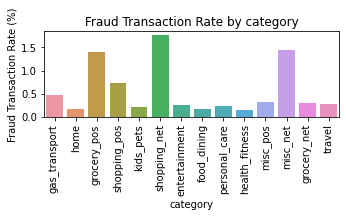

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5, 3))
def fraud_rate_by_category(feature):
    trnsctn_per_category = train_data[feature].value_counts()
    frauds_per_category = train_data[train_data.is_fraud == 1][feature].value_counts()
    fraud_percentage = frauds_per_category / trnsctn_per_category * 100
    fraud_percentage = fraud_percentage[cat_count_legit.index]
    
    sns.barplot(x=fraud_percentage.index, y=fraud_percentage)
    plt.xticks(rotation=90)
    plt.xlabel(feature)
    plt.ylabel("Fraud Transaction Rate (%)")
    plt.title(f"Fraud Transaction Rate by {feature}")
    plt.tight_layout()
    plt.show()
fraud_rate_by_category("category")

In [28]:
train_data.gender = train_data.gender.map({"M":0,"F":1})
test_data.gender = test_data.gender.map({"M":0,"F":1})

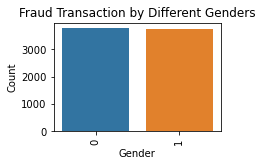

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(3, 2))
sns.countplot(data=train_data[train_data.is_fraud == 1], x='gender')
plt.title("Fraud Transaction by Different Genders")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

### Feature engineering

In [30]:
from datetime import datetime,date

In [31]:
train_data.dob = pd.to_datetime(train_data.dob)

In [32]:
train_data['age'] = 2023 - train_data.dob.dt.year

In [33]:
test_data.dob = pd.to_datetime(test_data.dob)
test_data['age'] = 2023 - test_data.dob.dt.year

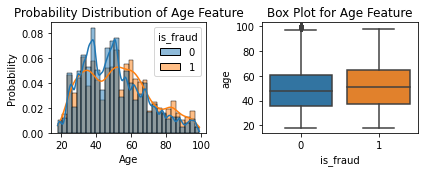

In [34]:
plt.figure(figsize=(6, 2.5))
plt.subplot(1, 2, 1)
sns.histplot(data=train_data, x="age", stat="probability", common_norm=False, hue="is_fraud", bins=30, kde=True)
plt.xlabel("Age")
plt.title("Probability Distribution of Age Feature")
plt.subplot(1, 2, 2)
sns.boxplot(data=train_data[["age", 'is_fraud']], x='is_fraud', y="age")
plt.title("Box Plot for Age Feature")
plt.tight_layout()
plt.show()

In [35]:
train_data['trans_date_trans_time'] = pd.to_datetime(train_data['trans_date_trans_time'])

In [36]:
test_data['trans_date_trans_time'] = pd.to_datetime(test_data['trans_date_trans_time'])

In [37]:
train_data["trans_date"] = train_data.trans_date_trans_time.dt.date
train_data["trans_time"] = train_data.trans_date_trans_time.dt.time
train_data["trans_hour"] = train_data["trans_time"].apply(lambda x: x.hour)
train_data["trans_month"] = train_data.trans_date_trans_time.dt.month
train_data["trans_week"] = train_data.trans_date_trans_time.dt.isocalendar().week

In [38]:
test_data["trans_date"] = test_data.trans_date_trans_time.dt.date
test_data["trans_time"] = test_data.trans_date_trans_time.dt.time
test_data["trans_hour"] = test_data["trans_time"].apply(lambda x: x.hour)
test_data["trans_month"] = test_data.trans_date_trans_time.dt.month
test_data["trans_week"] = test_data.trans_date_trans_time.dt.isocalendar().week

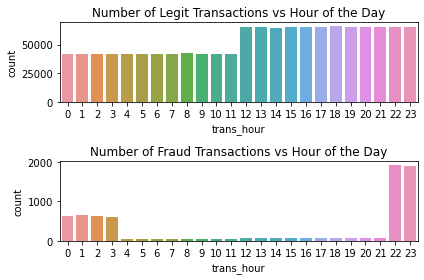

In [39]:
plt.figure(figsize=(6, 4))
plt.subplot(2, 1, 1)
sns.countplot(data=train_data[train_data.is_fraud == 0], x='trans_hour')
plt.title("Number of Legit Transactions vs Hour of the Day")
plt.subplot(2, 1, 2)
sns.countplot(data=train_data[train_data.is_fraud == 1], x='trans_hour')
plt.title("Number of Fraud Transactions vs Hour of the Day")
plt.tight_layout()
plt.show()

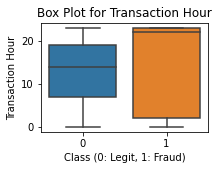

In [40]:
plt.figure(figsize=(3, 2))
sns.boxplot(data=train_data, x='is_fraud', y='trans_hour')
plt.title("Box Plot for Transaction Hour")
plt.xlabel("Class (0: Legit, 1: Fraud)")
plt.ylabel("Transaction Hour")
plt.show()

In [41]:
len(train_data.cc_num.unique()) 

983

In [42]:
train_data['card_trans_tot'] = train_data.groupby("cc_num")['trans_date_trans_time'].transform('count')

In [43]:
test_data['card_trans_tot'] = test_data.groupby("cc_num")['trans_date_trans_time'].transform('count')

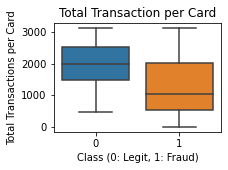

In [44]:
plt.figure(figsize=(3, 2))
sns.boxplot(data=train_data, x='is_fraud', y='card_trans_tot')
plt.title("Total Transaction per Card")
plt.xlabel("Class (0: Legit, 1: Fraud)")
plt.ylabel("Total Transactions per Card")
plt.show()

In [45]:
train_data['card_trans_by_date'] = train_data.groupby(["cc_num", "trans_date"])['trans_date_trans_time'].transform('count')

In [46]:
test_data['card_trans_by_date'] = test_data.groupby(["cc_num", "trans_date"])['trans_date_trans_time'].transform('count')

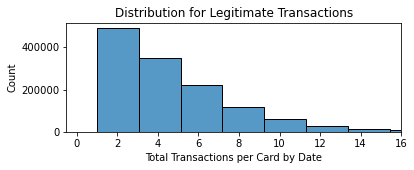

In [47]:
plt.figure(figsize=(6, 2))
sns.histplot(train_data[train_data.is_fraud == 0], x='card_trans_by_date', bins=16, kde=False)
plt.title("Distribution for Legitimate Transactions")
plt.xlim(-0.5, 16)
plt.xlabel("Total Transactions per Card by Date")
plt.ylabel("Count")
plt.show()

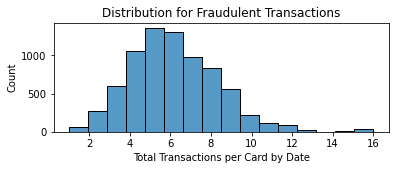

In [48]:
plt.figure(figsize=(6, 2))
sns.histplot(train_data[train_data.is_fraud == 1], x='card_trans_by_date', bins=16, kde=False)
plt.title("Distribution for Fraudulent Transactions")
plt.xlabel("Total Transactions per Card by Date")
plt.ylabel("Count")
plt.show()

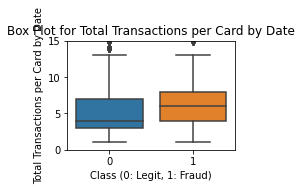

In [49]:
plt.figure(figsize=(3, 2))
sns.boxplot(data=train_data, x='is_fraud', y='card_trans_by_date')
plt.title("Box Plot for Total Transactions per Card by Date")
plt.xlabel("Class (0: Legit, 1: Fraud)")
plt.ylabel("Total Transactions per Card by Date")
plt.ylim(0, 15)
plt.show()

In [50]:
train_data['card_trans_by_month'] = train_data.groupby(["cc_num", "trans_month"])['trans_date_trans_time'].transform('count')

In [51]:
test_data['card_trans_by_month'] = test_data.groupby(["cc_num", "trans_month"])['trans_date_trans_time'].transform('count')

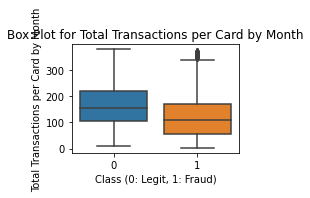

In [52]:
plt.figure(figsize=(3, 2))
sns.boxplot(data=train_data, x='is_fraud', y='card_trans_by_month')
plt.title("Box Plot for Total Transactions per Card by Month")
plt.xlabel("Class (0: Legit, 1: Fraud)")
plt.ylabel("Total Transactions per Card by Month")
plt.show()

In [53]:
train_data['card_trans_by_week'] = train_data.groupby(["cc_num", "trans_week"])['trans_date_trans_time'].transform('count')

In [54]:
test_data['card_trans_by_week'] = test_data.groupby(["cc_num", "trans_week"])['trans_date_trans_time'].transform('count')

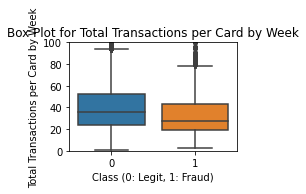

In [55]:
plt.figure(figsize=(3, 2))
sns.boxplot(data=train_data, x='is_fraud', y='card_trans_by_week')
plt.title("Box Plot for Total Transactions per Card by Week")
plt.xlabel("Class (0: Legit, 1: Fraud)")
plt.ylabel("Total Transactions per Card by Week")
plt.ylim(0, 100)
plt.show()

In [56]:
## Although, I constructed the following feature, it was not very helpful, thus
# ## Distance between merchant and customer
# def haversine_distance(lat1, lon1, lat2, lon2):
# # Radius of the Earth in kilometers
# R = 6371
# # Convert latitude and longitude from degrees to radians
# lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
# # Haversine formula
# dlat = lat2 - lat1
# dlon = lon2 - lon1
# a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
# c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
# distance = R * c
# return distance
# train_data["merch_distance"] = train_data.apply(lambda row:haversine_distance

## Correlation between features

In [57]:
train_data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'age', 'trans_date',
       'trans_time', 'trans_hour', 'trans_month', 'trans_week',
       'card_trans_tot', 'card_trans_by_date', 'card_trans_by_month',
       'card_trans_by_week'],
      dtype='object')

In [58]:
correlations = train_data[['is_fraud', 'amt', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop',
                            'unix_time', 'trans_hour', 'trans_date', 'trans_month', 'card_trans_tot', 'card_trans_by_date',
                            'card_trans_by_week', 'card_trans_by_month', 'age']].corr()


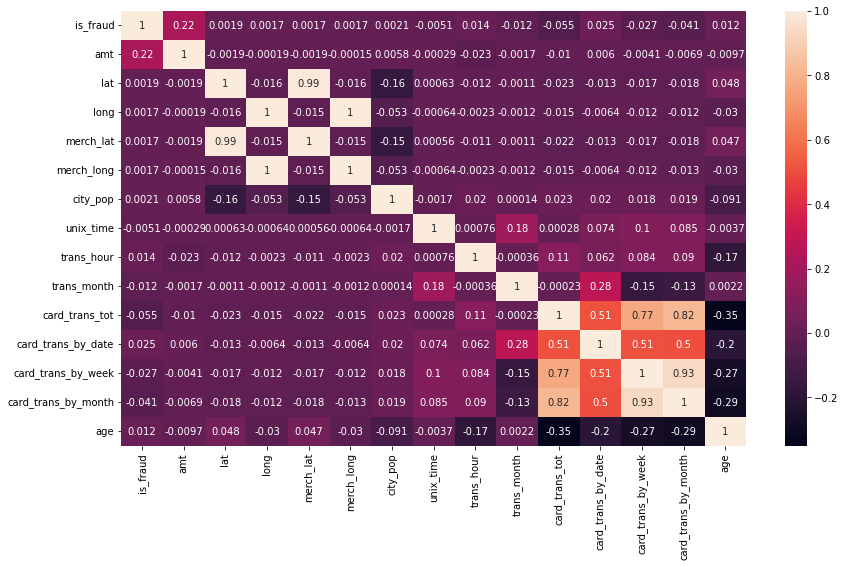

In [59]:
plt.figure(figsize=(14, 8))
sns.heatmap(correlations,annot=True)
plt.show()

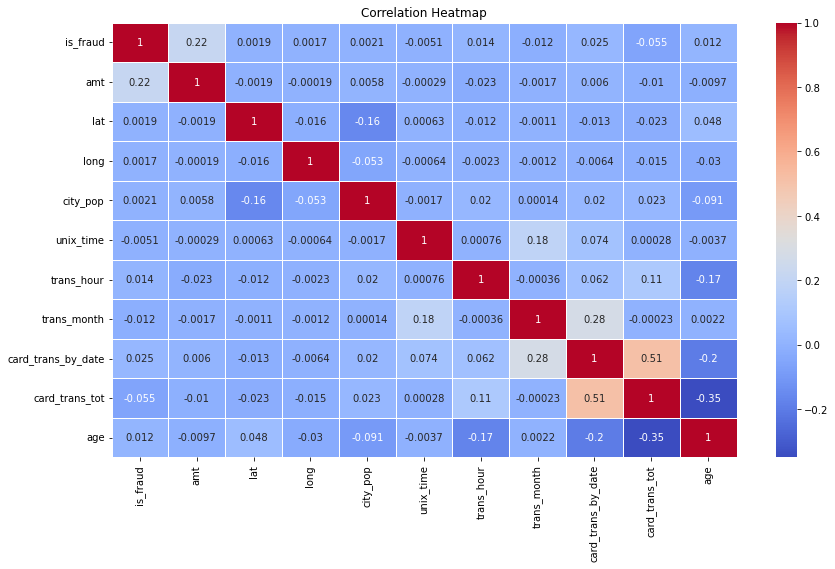

In [60]:
columns_of_interest = ['is_fraud', 'amt', 'lat', 'long', 'city_pop', 'unix_time',
                         'trans_hour', 'trans_month', 'card_trans_by_date',
                         'card_trans_tot', 'age']

correlations = train_data[columns_of_interest].corr()

plt.figure(figsize=(14, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

# Data Preprocessing for Modelling

In [61]:
final_num_columns = ['amt', 'lat', 'long', 'city_pop', 'unix_time',
 'trans_hour', 'trans_month','card_trans_by_date',
 'card_trans_tot','age']
final_cat_columns = ['category',"gender"]
final_columns=final_num_columns+final_cat_columns

In [62]:
X_train = train_data[final_columns]
y_train = train_data["is_fraud"]

In [63]:
X_train.shape, y_train.shape

((1296675, 12), (1296675,))

In [64]:
X_test = test_data[final_columns]
y_test = test_data["is_fraud"]

In [65]:
X_test.shape, y_test.shape

((555719, 12), (555719,))

In [66]:
print("Ratio of minority samples to majority samples:", round(y_train.value_counts()[1] / y_train.value_counts()[0], 4))

Ratio of minority samples to majority samples: 0.0058


# Scaling and Encoding

In [67]:
preprocessor = ColumnTransformer(
 transformers=[
 ('num', StandardScaler(),final_num_columns),
 ('cat', OneHotEncoder(),final_cat_columns)
 ])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)


In [68]:
transformed_feature_names = []
transformed_feature_names.extend(final_num_columns)
encoder = preprocessor.named_transformers_['cat']
transformed_feature_names.extend(encoder.get_feature_names_out())
X_train = pd.DataFrame(X_train, columns=transformed_feature_names)
X_test = pd.DataFrame(X_test, columns=transformed_feature_names)

In [69]:
X_train.head()

,amt,lat,long,city_pop,unix_time,trans_hour,trans_month,card_trans_by_date,card_trans_tot,age,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_0,gender_1
0,-0.407826,-0.484420,0.657620,-0.282589,-1.858664,-1.878145,-1.504564,-0.625294,0.281849,-0.848322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.230039,2.039120,-2.033870,-0.293670,-1.858662,-1.878145,-1.504564,1.565302,1.631335,-0.272898,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.934149,0.717754,-1.601537,-0.280406,-1.858662,-1.878145,-1.504564,-1.251179,-1.772008,0.647781,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.158132,1.515617,-1.590766,-0.287742,-1.858660,-1.878145,-1.504564,-0.938237,-1.785476,0.360069,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.177094,-0.023035,0.782279,-0.293835,-1.858651,-1.878145,-1.504564,-0.312352,0.267035,-0.733237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Sampling

In [70]:
#!pip install -U imbalanced-learn

In [71]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [72]:
#sampler = RandomOverSampler(sampling_strategy='auto',random_state=42)
#X_train_tfidf,y_train = sampler.fit_resample(X_train_tfidf,y_train)

In [73]:
#smote = SMOTE(sampling_strategy=0.01, random_state=42)
#X_train, y_train = smote.fit_resample(X_train, y_train)

In [74]:
print("Ratio of minority samples to majority samples:", round(y_train.value_counts()[1] / y_train.value_counts()[0], 4))

Ratio of minority samples to majority samples: 0.0058


In [75]:
sampler = RandomUnderSampler(sampling_strategy=0.05,random_state=42)
X_train,y_train = sampler.fit_resample(X_train,y_train)

In [76]:
y_train.value_counts()

0    150120
1      7506
Name: is_fraud, dtype: int64

In [77]:
print("Cross validation scores for different sampling strategies :\n")
dict1 = {
    'Sampling_strategy': ["No sampling", "Random under, ratio=0.01", "Random under, ratio=0.05", "Random under, ratio=0.1", "Random under, ratio=0.2"],
    'Mean_ROC_AUC_score': [0.965, 0.980, 0.986, 0.984, 0.981],
    "Standard_deviation": [0.034, 0.001, 0.001, 0.005, 0.013]
}

df = pd.DataFrame(dict1)
print(df)

Cross validation scores for different sampling strategies :

          Sampling_strategy  Mean_ROC_AUC_score  Standard_deviation
0               No sampling               0.965               0.034
1  Random under, ratio=0.01               0.980               0.001
2  Random under, ratio=0.05               0.986               0.001
3   Random under, ratio=0.1               0.984               0.005
4   Random under, ratio=0.2               0.981               0.013


# Machine Learning Models

In [78]:
plt.rcParams["figure.figsize"] = (5, 3)

def evaluate_metrics(model):
    y_train_pred = model.predict(X_train)
    y_train_scores = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_scores = model.predict_proba(X_test)[:, 1]

    print(f"Train accuracy : {accuracy_score(y_train, y_train_pred):.2f}")
    print(f"Test accuracy : {accuracy_score(y_test, y_test_pred):.2f}\n")

    print(f"Train macro f1 score : {f1_score(y_train, y_train_pred, average='macro'):.2f}")
    print(f"Test macro f1 score : {f1_score(y_test, y_test_pred, average='macro'):.2f}")

    print(f"Train ROC AUC score : {roc_auc_score(y_train, y_train_scores):.2f}")
    print(f"Test ROC AUC score : {roc_auc_score(y_test, y_test_scores):.2f}\n")

    # For test data only
    print("\nClassification report for test data:\n")
    print(classification_report(y_test, y_test_pred))

    print("\nConfusion matrix for test data:")
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Non-Fraud', 'Fraud'])
    disp.plot(xticks_rotation=90)
    plt.show()
    print()

    fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
    roc_auc = roc_auc_score(y_test, y_test_scores)

    plt.figure(figsize=(5, 3))
    plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label="Random classifier")

    plt.xlim([-0.001, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print("ROC AUC for test data :")
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

## Baseline Model using DummyClassifier 

In [79]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.dummy import DummyClassifier
hyp_params = {"strategy": ["most_frequent", "prior", "stratified", "uniform"]}
stratified_cv = StratifiedKFold(n_splits=5)
model = GridSearchCV(DummyClassifier(random_state=42),
                     param_grid=hyp_params,
                     cv=stratified_cv,
                     n_jobs=-1,
                     verbose=1,
                     scoring='roc_auc'
                     )
model.fit(X_train, y_train)
print("Best Hyperparameters:", model.best_params_)
best_model = model.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters: {'strategy': 'stratified'}


In [80]:
print("Cross validation Roc_Auc score for the best model:\n")
print(f"Mean score: {model.cv_results_['mean_test_score']}")
print(f"Standard deviation: {model.cv_results_['std_test_score']}")

Cross validation Roc_Auc score for the best model:

Mean score: [0.5        0.5        0.50300093 0.5       ]
Standard deviation: [0.00000000e+00 0.00000000e+00 4.35573384e-07 0.00000000e+00]


Train accuracy : 0.91
Test accuracy : 0.95

Train macro f1 score : 0.50
Test macro f1 score : 0.49
Train ROC AUC score : 0.50
Test ROC AUC score : 0.50


Classification report for test data:

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    553574
           1       0.00      0.05      0.01      2145

    accuracy                           0.95    555719
   macro avg       0.50      0.50      0.49    555719
weighted avg       0.99      0.95      0.97    555719


Confusion matrix for test data:


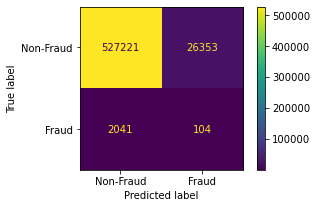

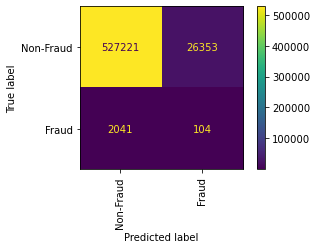


ROC AUC for test data :


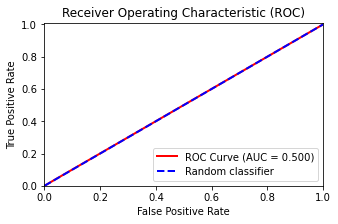

In [81]:
dummy_clf = DummyClassifier(strategy="stratified",random_state = 42)
dummy_clf.fit(X_train,y_train)
evaluate_metrics(dummy_clf)


# Logistic Regression

###  Hyperparameter Tuning

In [82]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define hyperparameter grid
hyp_params = {
    "penalty": ['l2'],
    "C": [0.1, 1.0],
    "solver": ['lbfgs']
}

stratified_cv = StratifiedKFold(n_splits=5)

log_reg = LogisticRegression(random_state=42, max_iter=10000, class_weight="balanced")

model = GridSearchCV(log_reg, param_grid=hyp_params, cv=stratified_cv, n_jobs=3, verbose=1, scoring='roc_auc', error_score='raise')

# Assuming X_train and y_train are defined elsewhere in your code
model.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", model.best_params_)

# Access the best model directly if needed
best_model = model.best_estimator_


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Hyperparameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}


In [83]:
model.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise',
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=42),
             n_jobs=3,
             param_grid={'C': [0.1, 1.0], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='roc_auc', verbose=1)

In [84]:
model.best_params_


{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}

In [85]:
print("Cross validation score, i.e. Roc_Auc, for the best model:\n")
print(f"Mean score: {model.cv_results_['mean_test_score']}")
print(f"Standard deviation: {model.cv_results_['std_test_score']}")

Cross validation score, i.e. Roc_Auc, for the best model:

Mean score: [0.91351639 0.9139827 ]
Standard deviation: [0.00730728 0.00725414]


In [86]:
from sklearn.model_selection import StratifiedKFold, cross_validate

def cv_scores(best_model):
    print("Cross-validation scores of the model with best hyperparameters:\n")
    
    scoring = {"roc_auc": "roc_auc", 'macro_f1': 'f1_macro', "accuracy": 'accuracy'}
    
    stratified_cv = StratifiedKFold(n_splits=5)
    
    results = cross_validate(best_model, X_train, y_train, cv=stratified_cv, scoring=scoring)
    
    print(f"roc_auc: mean = {round(results['test_roc_auc'].mean(), 3)}, std deviation = {round(results['test_roc_auc'].std(), 3)}")
    print(f"macro f1: mean = {round(results['test_macro_f1'].mean(), 3)}, std deviation = {round(results['test_macro_f1'].std(), 3)}")
    print(f"accuracy: mean = {round(results['test_accuracy'].mean(), 3)}, std deviation = {round(results['test_accuracy'].std(), 3)}")

# Assuming X_train and y_train are defined elsewhere in your code
cv_scores(best_model)


Cross-validation scores of the model with best hyperparameters:

roc_auc: mean = 0.914, std deviation = 0.007
macro f1: mean = 0.687, std deviation = 0.006
accuracy: mean = 0.901, std deviation = 0.002


### Evaluation Metrics


In [87]:
log_reg_final = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', random_state=42, max_iter=10000, class_weight="balanced")

log_reg_final.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)

Train accuracy : 0.90
Test accuracy : 0.76

Train macro f1 score : 0.70
Test macro f1 score : 0.45
Train ROC AUC score : 0.94
Test ROC AUC score : 0.92


Classification report for test data:

              precision    recall  f1-score   support

           0       1.00      0.76      0.86    553574
           1       0.01      0.86      0.03      2145

    accuracy                           0.76    555719
   macro avg       0.51      0.81      0.45    555719
weighted avg       1.00      0.76      0.86    555719


Confusion matrix for test data:


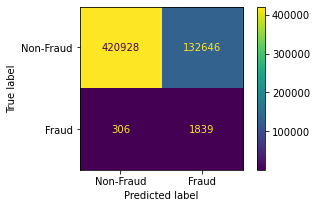

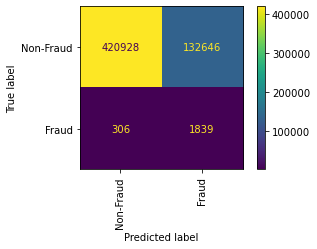


ROC AUC for test data :


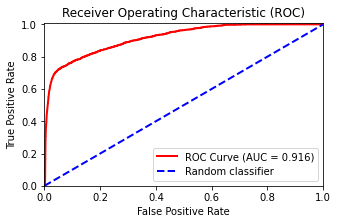

In [88]:
evaluate_metrics(log_reg_final)

# Decision Tree Classifier

###  Hyperparameter Tuning

In [89]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
hyp_params = {
    'max_depth': [10],
    'max_features': ['log2'],
    'max_leaf_nodes': [None],
    'min_samples_leaf': [2],
    'min_samples_split': [2]
}

stratified_cv = StratifiedKFold(n_splits=5)
model = GridSearchCV(DecisionTreeClassifier(random_state=42, class_weight='balanced'),
                     param_grid=hyp_params,
                     cv=stratified_cv,
                     n_jobs=3,
                     verbose=1,
                     scoring='roc_auc')
model.fit(X_train, y_train)
print("Best Hyperparameters:", model.best_params_)
best_model = model.best_estimator_


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [90]:
model.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=3,
             param_grid={'max_depth': [10], 'max_features': ['log2'],
                         'max_leaf_nodes': [None], 'min_samples_leaf': [2],
                         'min_samples_split': [2]},
             scoring='roc_auc', verbose=1)

In [91]:
model.best_params_

{'max_depth': 10,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [92]:
model.best_score_

0.8115252975711975

In [93]:
from sklearn.model_selection import cross_validate, StratifiedKFold
import numpy as np
best_model = DecisionTreeClassifier(
    max_depth=10,
    max_features='log2',
    max_leaf_nodes=None,
    min_samples_leaf=2,
    min_samples_split=2,
    class_weight='balanced',
    random_state=42
)
stratified_cv = StratifiedKFold(n_splits=5)
results = cross_validate(best_model, X_train, y_train, cv=stratified_cv, scoring=['roc_auc', 'f1_macro', 'accuracy'])
print("Cross-validation scores of the model with best hyperparameters:\n")
print(f"ROC AUC: mean = {np.mean(results['test_roc_auc']):.3f}, std deviation = {np.std(results['test_roc_auc']):.3f}")
print(f"Macro F1: mean = {np.mean(results['test_f1_macro']):.3f}, std deviation = {np.std(results['test_f1_macro']):.3f}")
print(f"Accuracy: mean = {np.mean(results['test_accuracy']):.3f}, std deviation = {np.std(results['test_accuracy']):.3f}")

Cross-validation scores of the model with best hyperparameters:

ROC AUC: mean = 0.812, std deviation = 0.117
Macro F1: mean = 0.709, std deviation = 0.066
Accuracy: mean = 0.919, std deviation = 0.020


### Evaluation Metrics 

In [94]:
decision_tree_final = best_model
decision_tree_final.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       max_features='log2', min_samples_leaf=2,
                       random_state=42)

Train accuracy : 0.95
Test accuracy : 0.81

Train macro f1 score : 0.80
Test macro f1 score : 0.47
Train ROC AUC score : 0.98
Test ROC AUC score : 0.87


Classification report for test data:

              precision    recall  f1-score   support

           0       1.00      0.81      0.90    553574
           1       0.02      0.90      0.04      2145

    accuracy                           0.81    555719
   macro avg       0.51      0.85      0.47    555719
weighted avg       1.00      0.81      0.89    555719


Confusion matrix for test data:


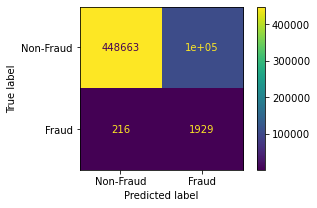

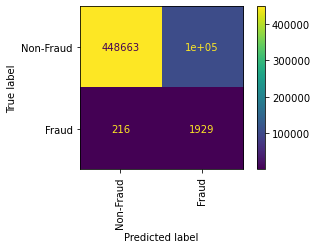


ROC AUC for test data :


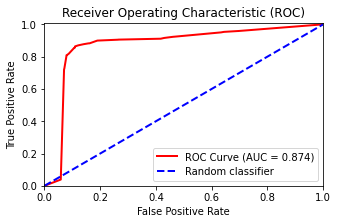

In [95]:
evaluate_metrics(decision_tree_final)

# Random Forest Classifier 

### Hyperparameter Tuning


In [96]:
stratified_cv = StratifiedKFold(n_splits=5)
hyp_params = {'max_depth': [100], 'min_samples_split': [5], 'n_estimators': [200]}
model = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
)
grid_search = GridSearchCV(model, param_grid=hyp_params, cv=stratified_cv, n_jobs=3, verbose=1, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters: {'max_depth': 100, 'min_samples_split': 5, 'n_estimators': 200}


In [97]:
model.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [98]:
print("Best Hyperparameters:", model.best_params_)


AttributeError: 'RandomForestClassifier' object has no attribute 'best_params_'

In [99]:
best_model = RandomForestClassifier(max_depth=100, min_samples_split=5, n_estimators=200, random_state=42)
cv_scores(best_model)

Cross-validation scores of the model with best hyperparameters:

roc_auc: mean = 0.989, std deviation = 0.002
macro f1: mean = 0.832, std deviation = 0.076
accuracy: mean = 0.977, std deviation = 0.008


### Evaluation Metrics 

In [100]:
random_forest_final = best_model
random_forest_final.fit(X_train,y_train)

RandomForestClassifier(max_depth=100, min_samples_split=5, n_estimators=200,
                       random_state=42)

Train accuracy : 1.00
Test accuracy : 0.92

Train macro f1 score : 0.99
Test macro f1 score : 0.52
Train ROC AUC score : 1.00
Test ROC AUC score : 0.97


Classification report for test data:

              precision    recall  f1-score   support

           0       1.00      0.92      0.96    553574
           1       0.04      0.88      0.07      2145

    accuracy                           0.92    555719
   macro avg       0.52      0.90      0.52    555719
weighted avg       1.00      0.92      0.95    555719


Confusion matrix for test data:


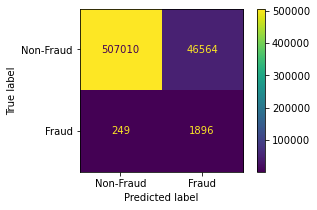

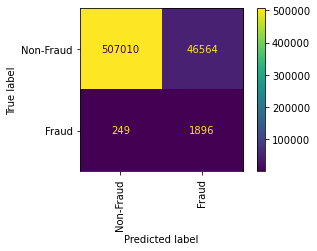


ROC AUC for test data :


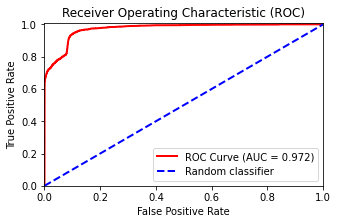

In [101]:
evaluate_metrics(random_forest_final)

# XGBoost classifier :
 

### Hyperparameter Tuning


In [102]:
class_weight_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
class_weight_ratio

20.0

In [103]:
hyp_params = {'learning_rate': [0.01, 0.1, 0.3],
              'max_depth': [3, 4],
              'n_estimators': [100, 200],
              'min_child_weight': [1, 2],
              'subsample': [0.8, 1.0],
              'scale_pos_weight': [1, 10, class_weight_ratio]
              }
hyp_params = {'learning_rate': [0.01], 'max_depth': [4], 'min_child_weight': [2], 'scale_pos_weight': [1]}
stratified_cv = StratifiedKFold(n_splits=5)
model = GridSearchCV(XGBClassifier(random_state=42),
                     param_grid=hyp_params, cv=stratified_cv, n_jobs=-1, verbose=1)


In [104]:
model.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [4],
                         'min_child_weight': [2], 'scale_pos_weight': [1]},
             verbose=1)

In [105]:
model.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 2,
 'scale_pos_weight': 1}

In [106]:
best_model = XGBClassifier(learning_rate=0.01, max_depth=4, min_child_weight=2,
                           n_estimators=200, subsample=0.8, scale_pos_weight=1, random_state=42)

cv_scores(best_model)


Cross-validation scores of the model with best hyperparameters:

roc_auc: mean = 0.98, std deviation = 0.001
macro f1: mean = 0.863, std deviation = 0.092
accuracy: mean = 0.98, std deviation = 0.01


In [107]:
xgb_final = best_model

In [108]:
xgb_final.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

Train accuracy : 0.99
Test accuracy : 0.92

Train macro f1 score : 0.91
Test macro f1 score : 0.51
Train ROC AUC score : 0.98
Test ROC AUC score : 0.95


Classification report for test data:

              precision    recall  f1-score   support

           0       1.00      0.92      0.96    553574
           1       0.04      0.78      0.07      2145

    accuracy                           0.92    555719
   macro avg       0.52      0.85      0.51    555719
weighted avg       1.00      0.92      0.95    555719


Confusion matrix for test data:


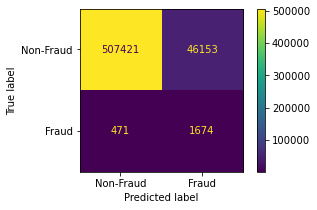

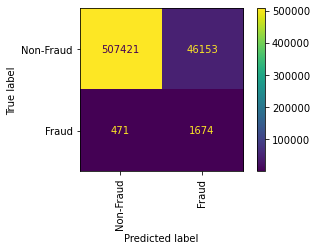


ROC AUC for test data :


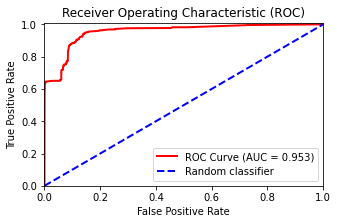

In [109]:
evaluate_metrics(xgb_final)

##  Feature Importance

In [110]:
feat_imp = pd.DataFrame(xgb_final.feature_importances_, index=X_train.columns, columns=['Importance'])
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

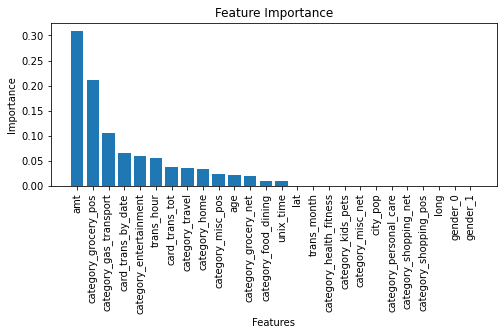

In [111]:
plt.figure(figsize=(8, 3))
plt.bar(feat_imp.index, feat_imp.iloc[:, 0])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


## Comparing Performance of Different Models

In [112]:
train_acc = []
test_acc = []
train_f1 = []
test_f1 = []
train_auc = []
test_auc = []

classifiers = [log_reg_final, decision_tree_final, random_forest_final, xgb_final]

for model in classifiers:
    y_train_pred = model.predict(X_train)
    y_train_scores = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_scores = model.predict_proba(X_test)[:, 1]

    train_acc.append(round(accuracy_score(y_train, y_train_pred), 2))
    test_acc.append(round(accuracy_score(y_test, y_test_pred), 2))
    train_f1.append(round(f1_score(y_train, y_train_pred, average='macro'), 2))
    test_f1.append(round(f1_score(y_test, y_test_pred, average='macro'), 2))
    train_auc.append(round(roc_auc_score(y_train, y_train_scores), 3))
    test_auc.append(round(roc_auc_score(y_test, y_test_scores), 3))

metrics = {
    "classifier": ["Logistic regression", "Decision tree", "Random Forest", "XGBoost"],
    "Train_accuracy": train_acc,
    "Test_accuracy": test_acc,
    "Train_f1_macro": train_f1,
    "Test_f1_macro": test_f1,
    "Train_ROC_AUC": train_auc,
    "Test_ROC_AUC": test_auc
}


In [113]:
pd.DataFrame(metrics)

,classifier,Train_accuracy,Test_accuracy,Train_f1_macro,Test_f1_macro,Train_ROC_AUC,Test_ROC_AUC
0,Logistic regression,0.90,0.76,0.70,0.45,0.938,0.916
1,Decision tree,0.95,0.81,0.80,0.47,0.979,0.874
2,Random Forest,1.00,0.92,0.99,0.52,1.000,0.972
3,XGBoost,0.99,0.92,0.91,0.51,0.983,0.953


# Conclusions